In [10]:
import argparse
import errno
import os
import random
from importlib.metadata import requires
from timeit import timeit
import dill as pickle
import numpy as np
import scipy
import torch
import wandb
import yaml
from sympy import Matrix, MatrixSymbol, derive_by_array, symarray
from torch.distributions import Categorical

import environment
import importlib
importlib.reload(environment)
from environment import GridWorld
from subrl.utils.network import append_state
from subrl.utils.network import policy as agent_net
from subrl.utils.visualization import Visu

In [11]:
workspace = "subrl"

params = {
    "env": {
        "start": 1,
        "step_size": 0.1,
        "shape": {"x": 11, "y": 18},
        "horizon": 80,
        "node_weight": "constant",
        "disc_size": "small",
        "n_players": 3,
        "Cx_lengthscale": 2,
        "Cx_noise": 0.001,
        "Fx_lengthscale": 1,
        "Fx_noise": 0.001,
        "Cx_beta": 1.5,
        "Fx_beta": 1.5,
        "generate": False,
        "env_file_name": 'env_data.pkl',
        "cov_module": 'Matern',
        "stochasticity": 0.0,
        "domains": "two_room_2",
        "num": 1,  # 替代原来的args.env
        "initial": 80
    },
    "alg": {
        "gamma": 1,
        "type": "NM",
        "ent_coef": 0.0,
        "epochs": 140,
        "lr": 0.02
    },
    "common": {
        "a": 1,
        "subgrad": "greedy",
        "grad": "pytorch",
        "algo": "both",
        "init": "deterministic",
        "batch_size": 3000
    },
    "visu": {
        "wb": "disabled",
        "a": 1
    }
}

print(params)

# 2) Set the path and copy params from file
env_load_path = workspace + \
    "/environments/" + params["env"]["node_weight"]+ "/env_" + \
    str(params["env"]["num"])



epochs = params["alg"]["epochs"]

H = params["env"]["horizon"]
MAX_Ret = 2*(H+1)
if params["env"]["disc_size"] == "large":
    MAX_Ret = 3*(H+2)

# 3) Setup the environement
env = GridWorld(
    env_params=params["env"], common_params=params["common"], visu_params=params["visu"], env_file_path=env_load_path)
node_size = params["env"]["shape"]['x']*params["env"]["shape"]['y']
# TransitionMatrix = torch.zeros(node_size, node_size)

if params["env"]["node_weight"] == "entropy" or params["env"]["node_weight"] == "steiner_covering" or params["env"]["node_weight"] == "GP": 
    a_file = open(env_load_path +".pkl", "rb")
    data = pickle.load(a_file)
    a_file.close()

if params["env"]["node_weight"] == "entropy":
    env.cov = data
if params["env"]["node_weight"] == "steiner_covering":
    env.items_loc = data
if params["env"]["node_weight"] == "GP":
    env.weight = data

visu = Visu(env_params=params["env"])

env.get_horizon_transition_matrix()




{'env': {'start': 1, 'step_size': 0.1, 'shape': {'x': 11, 'y': 18}, 'horizon': 80, 'node_weight': 'constant', 'disc_size': 'small', 'n_players': 3, 'Cx_lengthscale': 2, 'Cx_noise': 0.001, 'Fx_lengthscale': 1, 'Fx_noise': 0.001, 'Cx_beta': 1.5, 'Fx_beta': 1.5, 'generate': False, 'env_file_name': 'env_data.pkl', 'cov_module': 'Matern', 'stochasticity': 0.0, 'domains': 'two_room_2', 'num': 1, 'initial': 80}, 'alg': {'gamma': 1, 'type': 'NM', 'ent_coef': 0.0, 'epochs': 140, 'lr': 0.02}, 'common': {'a': 1, 'subgrad': 'greedy', 'grad': 'pytorch', 'algo': 'both', 'init': 'deterministic', 'batch_size': 3000}, 'visu': {'wb': 'disabled', 'a': 1}}
x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001, 14.4999, 14.5001, 15.4999, 15.5001, 16.4999, 16.5001, 17.4999, 17.5001]
y_ticks [-0.5001, -0.499

In [48]:
def sample_excellent_trajectories(filepath="two_Room_80_go_explore_archive_file.pkl", 
                                  method='top_n', 
                                  n=10, 
                                  p=0.1, 
                                  threshold=0):
    """
        Load data from the Go-Explore archive and sample high-quality trajectories based on the specified method.

        Args:
            filepath (str): Path to the .pkl archive file.
            method (str): Sampling method. Options are 'top_n', 'top_p', or 'threshold'.
            n (int): Number of trajectories to sample for the 'top_n' method.
            p (float): Percentage of top trajectories to sample for the 'top_p' method (e.g., 0.1 means top 10%).
            threshold (float): Minimum reward threshold for the 'threshold' method.
        
        Returns:
            list: A list of trajectory dictionaries with high rewards, sorted in descending order of reward.
                  Returns an empty list if the file does not exist or the archive is empty.
    """
    # 1. Check if the file exists and load the data
    if not os.path.exists(filepath):
        print(f"Error: Archive file not found '{filepath}'")
        return []
    
    try:
        with open(filepath, "rb") as f:
            archive = pickle.load(f)
        if not archive:
            print("警告：存檔庫為空。")
            return []
    except Exception as e:
        print(f"讀取文件時出錯: {e}")
        return []

    # 2. 提取所有軌跡數據並按獎勵排序
    # archive.values() 返回的是包含 reward, states, actions 等信息的字典
    all_trajectories_data = list(archive.values())
    
    # 按 'reward' 鍵從高到低排序
    all_trajectories_data.sort(key=lambda x: x['reward'], reverse=True)

    # 3. 根據指定方法進行採樣
    sampled_trajectories = []
    if method == 'top_n':
        # 取獎勵最高的前 N 條
        num_to_sample = min(n, len(all_trajectories_data))
        sampled_trajectories = all_trajectories_data[:num_to_sample]
        print(f"方法: Top-N。從 {len(all_trajectories_data)} 條軌跡中篩選出最好的 {len(sampled_trajectories)} 條。")

    elif method == 'top_p':
        # 取獎勵最高的前 P%
        if not (0 < p <= 1):
            print("錯誤：百分比 'p' 必須在 (0, 1] 之間。")
            return []
        num_to_sample = int(len(all_trajectories_data) * p)
        sampled_trajectories = all_trajectories_data[:num_to_sample]
        print(f"方法: Top-P。從 {len(all_trajectories_data)} 條軌跡中篩選出最好的前 {p*100:.1f}% ({len(sampled_trajectories)} 條)。")

    elif method == 'threshold':
        # 取獎勵高於指定門檻的所有軌跡
        sampled_trajectories = [data for data in all_trajectories_data if data['reward'] >= threshold]
        print(f"方法: Threshold。從 {len(all_trajectories_data)} 條軌跡中篩選出 {len(sampled_trajectories)} 條獎勵不低於 {threshold} 的軌跡。")
        
    else:
        print(f"錯誤：未知的採樣方法 '{method}'。請使用 'top_n', 'top_p', 或 'threshold'。")

    return sampled_trajectories


In [49]:
top_20_trajectories = sample_excellent_trajectories(method='top_n', n=100)
if top_20_trajectories:
    print(f"其中最好的一條獎勵為: {top_20_trajectories[0]['reward']}")
    print(f"最差的一條（在這20條中）獎勵為: {top_20_trajectories[-1]['reward']}\n")

方法: Top-N。從 5202 條軌跡中篩選出最好的 100 條。
其中最好的一條獎勵為: 137
最差的一條（在這20條中）獎勵為: 137



In [50]:
def create_path_with_timesteps(states):
    """
    从轨迹数据创建带时间步的路径
    """
    # 将状态转换为带时间步的格式
    path_with_time = [(t, state.item()) for t, state in enumerate(states)]
    return path_with_time
mat_state = top_20_trajectories[0]["states"].copy()
path = create_path_with_timesteps(mat_state)
print(path)

[(0, 80), (1, 79), (2, 78), (3, 77), (4, 76), (5, 58), (6, 40), (7, 39), (8, 38), (9, 20), (10, 2), (11, 1), (12, 0), (13, 18), (14, 36), (15, 54), (16, 72), (17, 73), (18, 91), (19, 90), (20, 108), (21, 126), (22, 144), (23, 145), (24, 163), (25, 164), (26, 165), (27, 147), (28, 148), (29, 130), (30, 112), (31, 111), (32, 93), (33, 75), (34, 76), (35, 77), (36, 78), (37, 79), (38, 80), (39, 81), (40, 82), (41, 83), (42, 84), (43, 85), (44, 86), (45, 68), (46, 50), (47, 49), (48, 48), (49, 30), (50, 12), (51, 13), (52, 14), (53, 15), (54, 16), (55, 34), (56, 52), (57, 70), (58, 88), (59, 106), (60, 124), (61, 142), (62, 160), (63, 178), (64, 177), (65, 159), (66, 158), (67, 157), (68, 175), (69, 174), (70, 156), (71, 138), (72, 120), (73, 121), (74, 122), (75, 104), (76, 86), (77, 68)]


x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001, 14.4999, 14.5001, 15.4999, 15.5001, 16.4999, 16.5001, 17.4999, 17.5001]
y_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001]
x [8, 7, 6, 5, 4, 4, 4, 3, 2, 2, 2, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 2, 3, 3, 4, 4, 4, 3, 3, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 14, 14, 13, 12, 12, 12, 13, 14, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 14, 13, 13, 12, 12, 12, 12, 13, 14, 14, 14, 14]
y [4, 4, 4, 4, 4, 3, 2, 2, 2, 1, 0, 0, 0, 1, 2, 3, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9, 8, 8, 7, 6, 6, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 2, 2, 1, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 

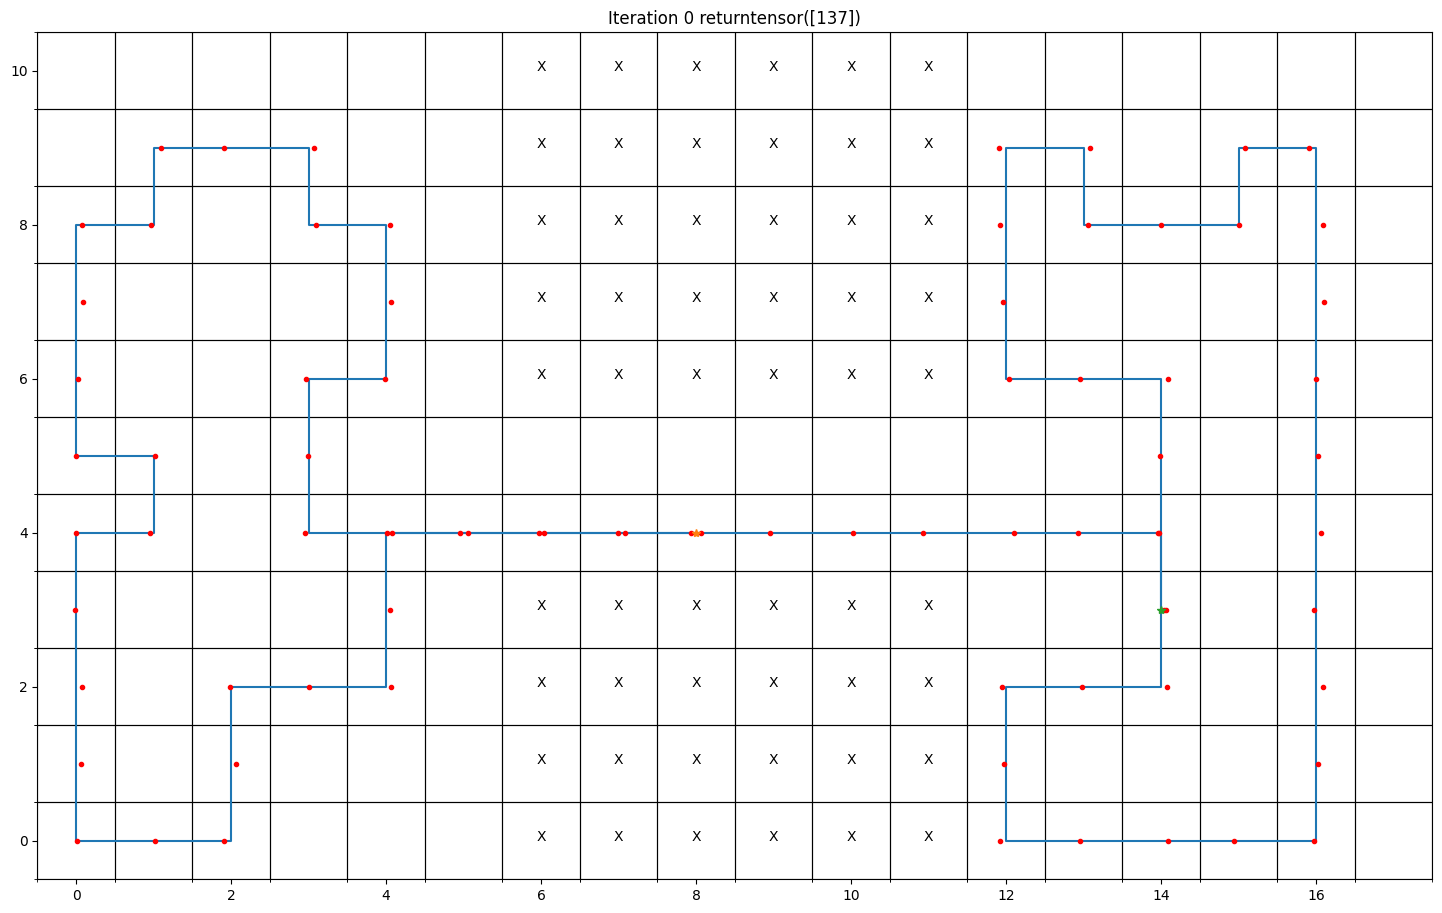

In [51]:
import importlib
import visualization
importlib.reload(visualization)
from visualization import Visu
visu = Visu(env_params=params["env"])
visu.path_return(env.weighted_traj_return(mat_state, type=params["alg"]["type"]))
visu.visu_path(path,env.Hori_ActionTransitionMatrix)

自定义最优奖励

79
x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001, 14.4999, 14.5001, 15.4999, 15.5001, 16.4999, 16.5001, 17.4999, 17.5001]
y_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001]
x [8, 7, 6, 5, 4, 3, 2, 2, 2, 3, 4, 4, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 3, 2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 11, 12, 12, 13, 14, 14, 14, 13, 12, 12, 12, 13, 14, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 14, 13, 12, 12, 12, 13, 14, 14, 14]
y [4, 4, 4, 4, 4, 4, 4, 3, 2, 2, 2, 1, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 9, 9, 9, 8, 7, 7, 7, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 5, 5, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 9, 8,

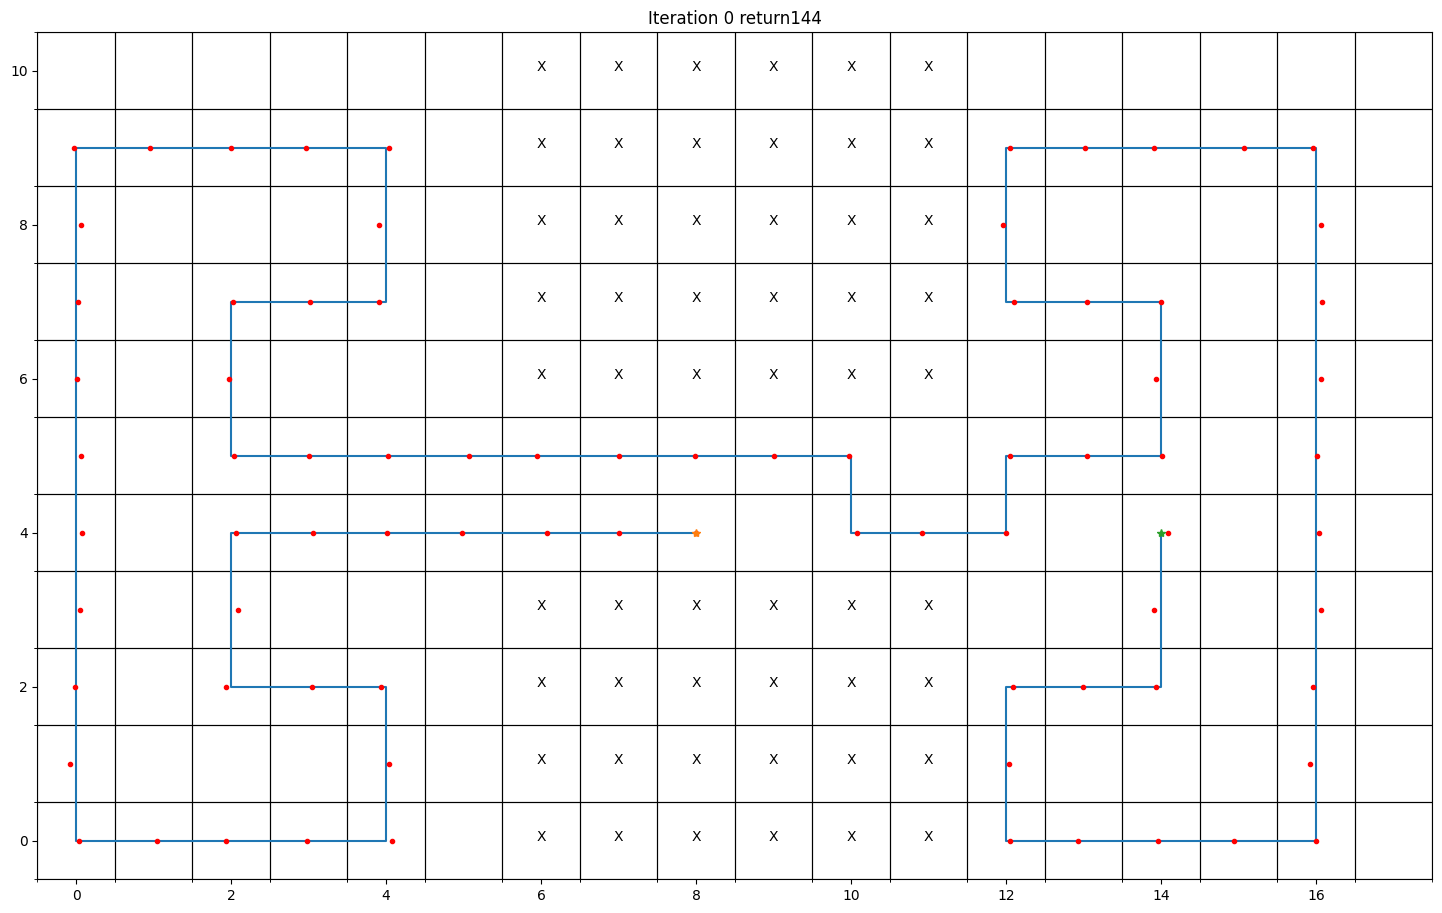

In [29]:
state = [80,79,78,77,76,75,74,56,38,39,40,22,4,3,2,1,0,18,36,54,72,90,108,126,144,162,163,164,165,166,148,130,129,128,110,92,93,94,95,96,97,98,99,100,82,83,84,102,103,104,122,140,139,138,156,174,175,176,177,178,160,142,124,106,88,70,52,34,16,15,14,13,12,30,48,49,50,68,86]
mat_state = [torch.tensor([state_i]) for state_i in state]
max_return = env.weighted_traj_return(mat_state, type=params["alg"]["type"])
print(len(state))
path = create_path_with_timesteps(mat_state)
visu = Visu(env_params=params["env"])
visu.path_return(max_return.item())
visu.visu_path(path,env.Hori_ActionTransitionMatrix)

In [30]:
mat_state = [torch.tensor([state_i]) for state_i in state]
env.weighted_traj_return(mat_state, type=params["alg"]["type"])

tensor([144])

测试覆盖奖励

[0.0, 6.0, 2, 2, 2, 0, 4, 2, 2, 2, 2, 0, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
144
x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001, 14.4999, 14.5001, 15.4999, 15.5001, 16.4999, 16.5001, 17.4999, 17.5001]
y_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001]
x [0, 1, 2, 3, 4, 5, 12

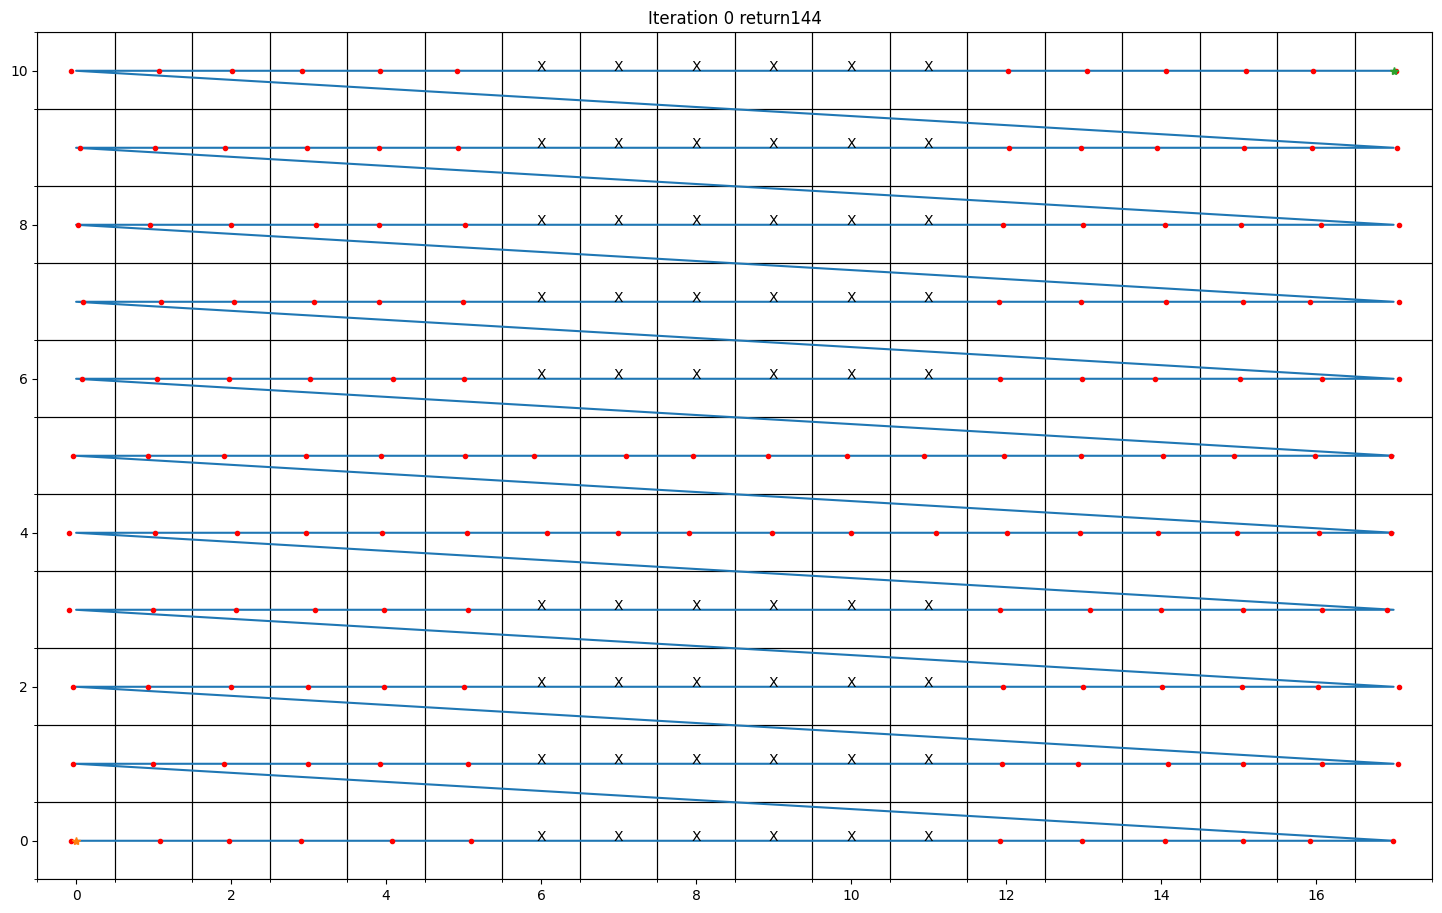

In [31]:
state = []
reward = []
mat_return = []
for cell in range(params["env"]["shape"]["y"] * params["env"]["shape"]["x"]):
    if env.Hori_ActionTransitionMatrix is not None:
        is_obstacle = True
        for action in range(env.action_dim):
            if env.Hori_ActionTransitionMatrix[cell, cell, action] != 1.0:
                is_obstacle = False
                break
        if not is_obstacle:
            state.append(cell)
            mat_state = [torch.tensor([state_i]) for state_i in state]
            mat_return.append(env.weighted_traj_return(mat_state, type=params["alg"]["type"]).item())
            if cell == 0:
                reward.append(mat_return[-1])
            else:
                reward.append(mat_return[-1] - mat_return[-2])
print(reward)
# state = [cell for cell in range(params["env"]["shape"]["y"] * params["env"]["shape"]["x"]) if cell not in [17, 4, 53, 146, 113]]
mat_state = [torch.tensor([state_i]) for state_i in state]
max_return = env.weighted_traj_return(mat_state, type=params["alg"]["type"])
print(len(state))
path = create_path_with_timesteps(mat_state)
visu = Visu(env_params=params["env"])
visu.path_return(max_return.item())
visu.visu_path(path,env.Hori_ActionTransitionMatrix)

79
x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001, 14.4999, 14.5001, 15.4999, 15.5001, 16.4999, 16.5001, 17.4999, 17.5001]
y_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001]
x [8, 7, 6, 5, 4, 3, 2, 2, 2, 3, 4, 4, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 3, 2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 11, 12, 12, 13, 14, 14, 14, 13, 12, 12, 12, 13, 14, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 14, 13, 12, 12, 12, 13, 14, 14, 14]
y [4, 4, 4, 4, 4, 4, 4, 3, 2, 2, 2, 1, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 9, 9, 9, 8, 7, 7, 7, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 5, 5, 5, 6, 7, 7, 7, 8, 9, 9, 9, 9, 9, 8,

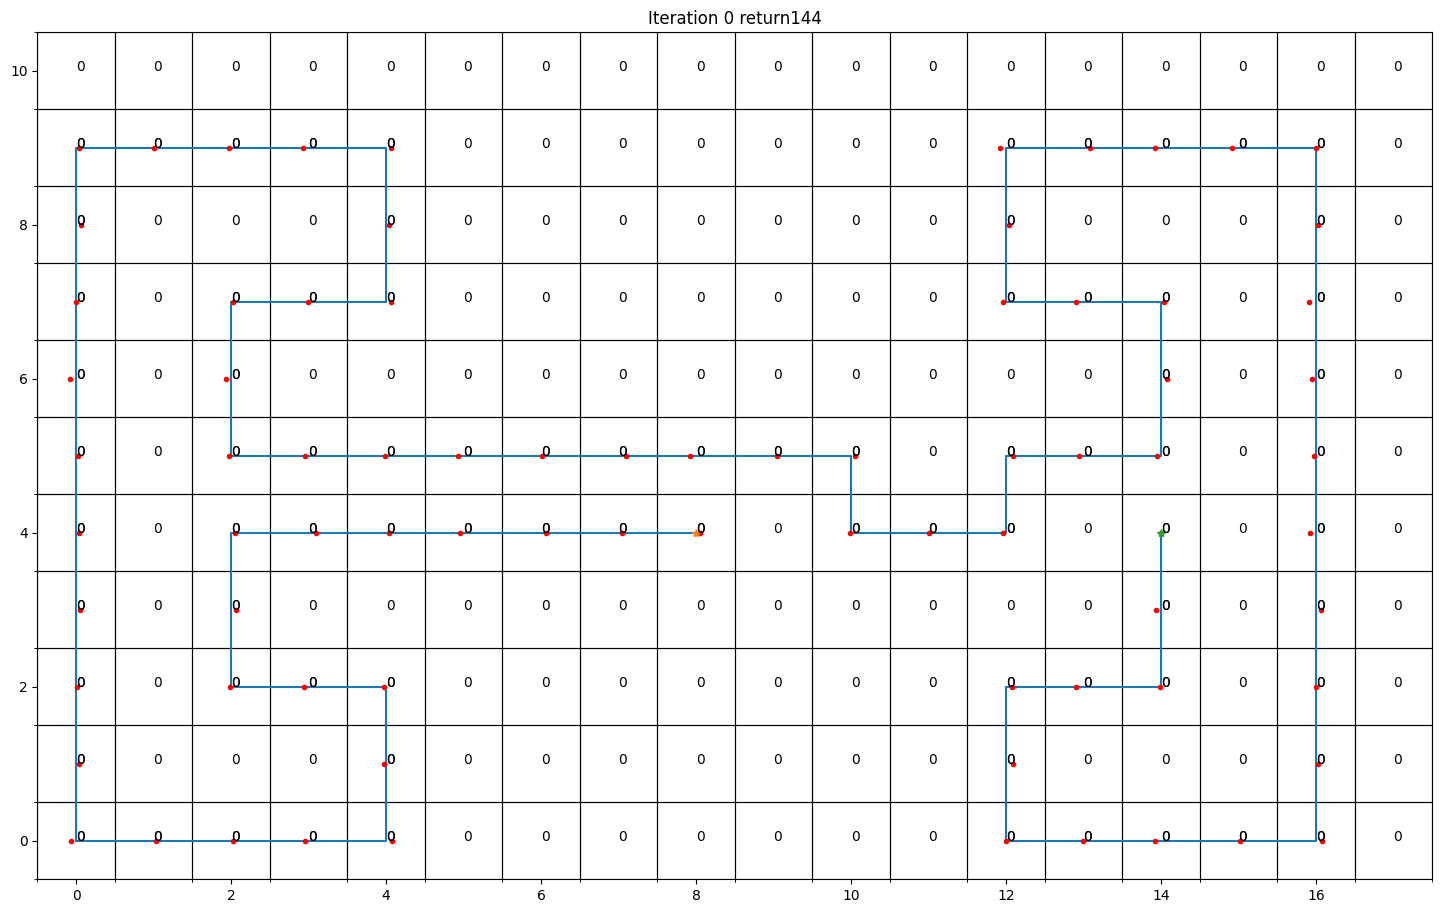

In [32]:
state = [80,79,78,77,76,75,74,56,38,39,40,22,4,3,2,1,0,18,36,54,72,90,108,126,144,162,163,164,165,166,148,130,129,128,110,92,93,94,95,96,97,98,99,100,82,83,84,102,103,104,122,140,139,138,156,174,175,176,177,178,160,142,124,106,88,70,52,34,16,15,14,13,12,30,48,49,50,68,86]
mat_state = [torch.tensor([state_i]) for state_i in state]
max_return = env.weighted_traj_return(mat_state, type=params["alg"]["type"])
print(len(state))
path = create_path_with_timesteps(mat_state)
visu = Visu(env_params=params["env"])
visu.path_return(max_return.item())
visu.visu_path_lb(path)

In [127]:
# 修改热力图函数，将障碍物用棕色表示
import importlib
import visualization
importlib.reload(visualization)
from visualization import Visu
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import ListedColormap

def visu_heatmap_with_obstacles(self, visit_frequency=None, path=None, title="Visit Frequency Heatmap"):
    """
    可视化热力图，显示访问频率或值分布，障碍物用棕色表示
    
    Args:
        visit_frequency: 字典或数组，包含每个格子的访问频率或值
        path: 可选的路径数据，格式为 [(t, s), ...]
        title: 图表标题
    """
    f, ax = plt.subplots(figsize=(self.x_shape, self.y_shape))
    
    # 创建热力图数据矩阵
    heatmap_data = np.zeros((self.y_shape, self.x_shape))
    obstacle_mask = np.zeros((self.y_shape, self.x_shape), dtype=bool)
    
    # 检测障碍物
    if hasattr(env, 'Hori_ActionTransitionMatrix') and env.Hori_ActionTransitionMatrix is not None:
        for cell in range(self.x_shape * self.y_shape):
            is_obstacle = True
            for action in range(env.action_dim):
                if env.Hori_ActionTransitionMatrix[cell, cell, action] != 1.0:
                    is_obstacle = False
                    break
            if is_obstacle:
                x_coord = cell % self.x_shape
                y_coord = int(cell / self.x_shape)
                obstacle_mask[y_coord, x_coord] = True
    
    # 填充访问频率数据
    if visit_frequency is not None:
        if isinstance(visit_frequency, dict):
            for key, value in visit_frequency.items():
                if isinstance(key, tuple):
                    s = key[1] if len(key) > 1 else key[0]
                else:
                    s = key
                x_coord = s % self.x_shape
                y_coord = int(s / self.x_shape)
                if 0 <= y_coord < self.y_shape and 0 <= x_coord < self.x_shape:
                    heatmap_data[y_coord, x_coord] += value
        elif isinstance(visit_frequency, (list, np.ndarray)):
            if len(visit_frequency) == self.x_shape * self.y_shape:
                heatmap_data = np.array(visit_frequency).reshape(self.y_shape, self.x_shape)
    
    # 创建自定义颜色映射
    # 对于障碍物，我们将使用棕色
    display_data = heatmap_data.copy()
    
    # 先绘制基础热力图
    im = ax.imshow(heatmap_data, cmap='viridis', aspect='equal', origin='lower', 
                   interpolation='nearest', alpha=0.8)
    
    # 在障碍物位置叠加棕色
    obstacle_data = np.ma.masked_where(~obstacle_mask, np.ones_like(heatmap_data))
    ax.imshow(obstacle_data, cmap='copper', aspect='equal', origin='lower', 
              interpolation='nearest', alpha=0.9, vmin=0, vmax=1)
    
    # 添加颜色条
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Visit Frequency', rotation=270, labelpad=15)
    
    # 设置网格
    ax.set_xticks(np.arange(-0.5, self.x_shape, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, self.y_shape, 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=1.0, alpha=0.7)
    
    # 设置主要刻度
    ax.set_xticks(np.arange(0, self.x_shape, 1))
    ax.set_yticks(np.arange(0, self.y_shape, 1))
    
    # 在每个格子中显示数值或障碍物标记
    for i in range(self.y_shape):
        for j in range(self.x_shape):
            if obstacle_mask[i, j]:
                # 障碍物显示 
                ax.text(j, i, '', ha="center", va="center", 
                       color="white", fontweight='bold', fontsize=12)
            elif heatmap_data[i, j] > 0:
                # 访问频率数值
                text_color = "white" if heatmap_data[i, j] < heatmap_data.max()/2 else "black"
                ax.text(j, i, f'{int(heatmap_data[i, j])}',
                       ha="center", va="center", 
                       color=text_color, fontweight='bold')
    
    # 如果有路径，绘制路径
    if path is not None:
        x_path = []
        y_path = []
        for cell in path:
            if isinstance(cell, tuple):
                cell_pos = cell[1] if len(cell) > 1 else cell[0]
            else:
                cell_pos = cell
            x_path.append(cell_pos % self.x_shape)
            y_path.append(int(cell_pos / self.x_shape))
        
        # 绘制路径线
        if len(x_path) > 1:
            ax.plot(x_path, y_path, 'r-', linewidth=3, alpha=0.8, label='Path')
        
        # 标记起点和终点
        if len(x_path) > 0:
            ax.plot(x_path[0], y_path[0], '*', color='orange', markersize=15, 
                   markeredgecolor='black', markeredgewidth=1, label='Start')
            if len(x_path) > 1:
                ax.plot(x_path[-1], y_path[-1], '*', color='lime', markersize=15,
                       markeredgecolor='black', markeredgewidth=1, label='End')
            ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    
    # 设置标题和标签
    ax.set_title(f"{title}\nMAX Return {self.ret:.2f}")
    ax.set_xlim(-0.5, self.x_shape-0.5)
    ax.set_ylim(-0.5, self.y_shape-0.5)
    
    # 设置坐标轴标签
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    
    plt.tight_layout()
    self.iter += 1
    return plt, f

def visu_state_visits_with_obstacles(self, states_list, path=None):
    """
    根据状态列表创建访问频率热力图，包含障碍物显示
    
    Args:
        states_list: 状态列表，可以是 [s1, s2, s3, ...] 或 [tensor1, tensor2, ...]
        path: 可选的路径数据
    """
    # 统计每个状态的访问次数
    visit_counts = {}
    
    for state in states_list:
        if isinstance(state, torch.Tensor):
            state_val = state.item()
        else:
            state_val = state
            
        if state_val in visit_counts:
            visit_counts[state_val] += 1
        else:
            visit_counts[state_val] = 1
    
    return self.visu_heatmap_with_obstacles(visit_counts, path, "State Visit Frequency")

# 动态添加新方法到 Visu 类
Visu.visu_heatmap_with_obstacles = visu_heatmap_with_obstacles
Visu.visu_state_visits_with_obstacles = visu_state_visits_with_obstacles

print("带障碍物显示的热力图功能已成功添加到 Visu 类！")

带障碍物显示的热力图功能已成功添加到 Visu 类！


x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001, 14.4999, 14.5001, 15.4999, 15.5001, 16.4999, 16.5001, 17.4999, 17.5001]
y_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001]
使用了前20条轨迹，总访问状态数: 7815


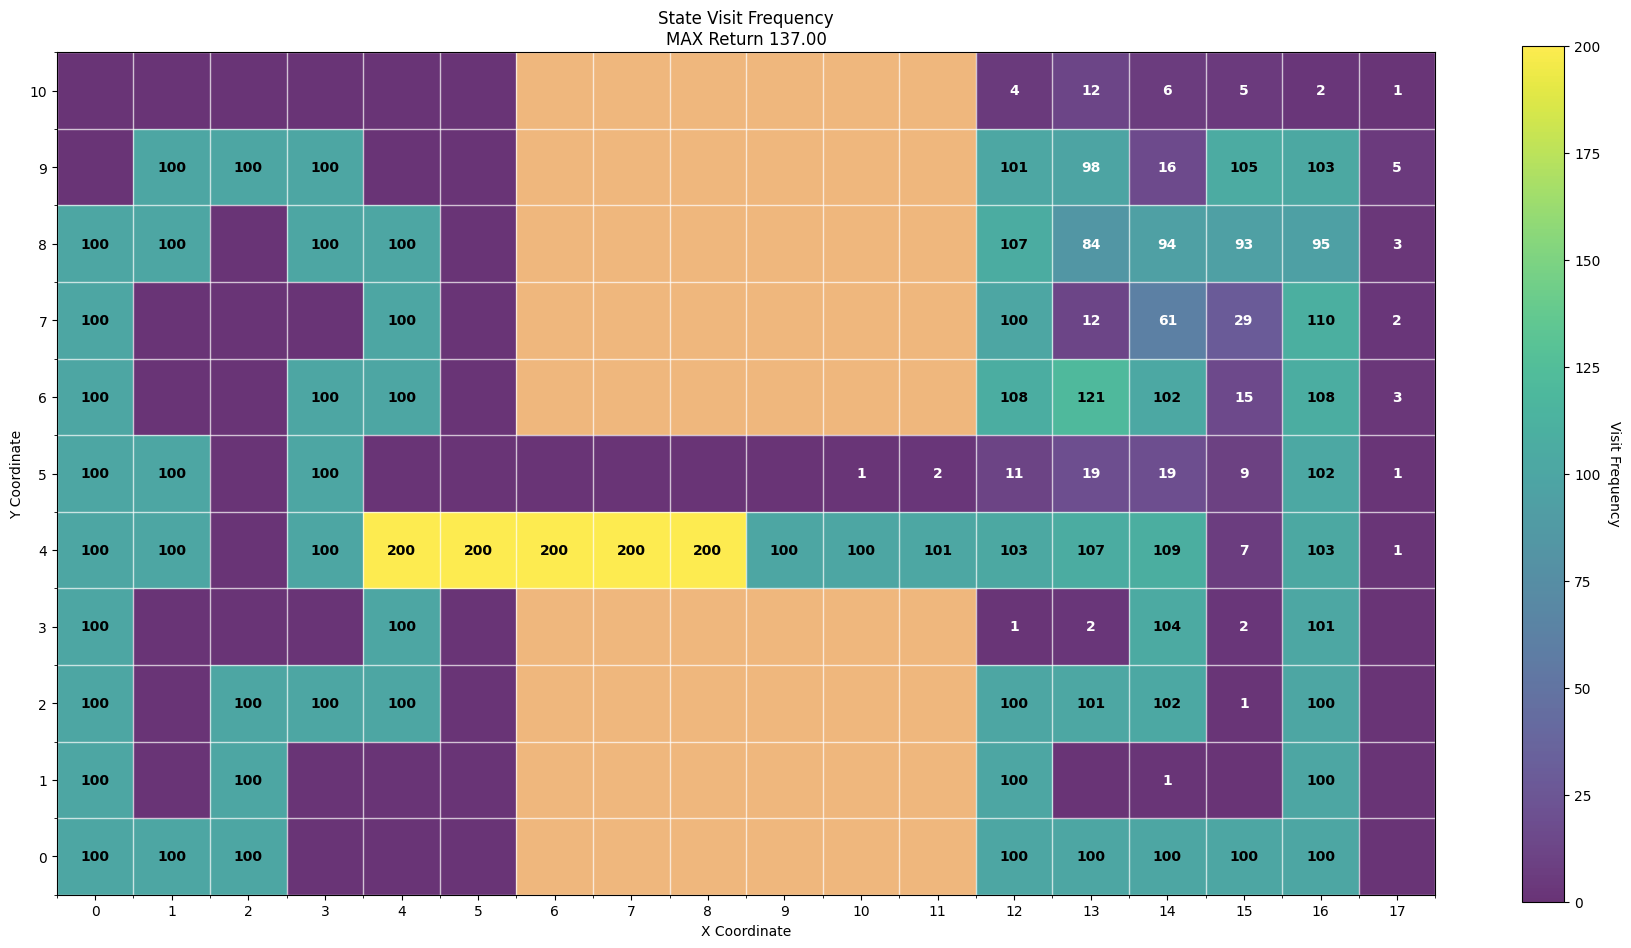

In [128]:
# 测试带障碍物的热力图功能

# 创建可视化对象
visu = Visu(env_params=params["env"])

# 统计前20条轨迹的访问频率
all_states = []
for traj in top_20_trajectories[:]:
    all_states.extend(traj["states"])

# 使用第一条轨迹作为路径显示
mat_state = top_20_trajectories[0]["states"].copy()
path = create_path_with_timesteps(mat_state)

# 设置返回值
max_return = env.weighted_traj_return(mat_state, type=params["alg"]["type"])
visu.path_return(max_return.item())

print(f"使用了前20条轨迹，总访问状态数: {len(all_states)}")

# 创建带障碍物的访问频率热力图
plt_heatmap, fig_heatmap = visu.visu_state_visits_with_obstacles(all_states)
plt_heatmap.show()